# Config file of an example using LSTM-KF-RL on a synthetic time series
This file include 
1. import data
2. training BDLM-LSTM model with hyper-parameters-free AR
3. check if the BDLM-LSTM model is correct (LSTM, AR, AA)
4. generate time series for RL agent training
5. train RL agents
6. evaluate the performance of RL agents

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import csv
import pandas as pd
import copy
import scipy.io as sio

from tqdm import tqdm
from datetime import datetime, timedelta
from src.RL_functions.generate_synthetic_time_series import *
from examples.data_loader import TimeSeriesDataloader
from pytagi import Normalizer as normalizer
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm
import pytagi.metric as metric
from pytagi import Normalizer

from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.BDLM_trainer import BDLM_trainer
from src.RL_functions.regime_change_detection_RLKF import regime_change_detection_RLKF

## 1. Import data

In [2]:
# Import data HQ TS2
time_series_path = './data/HQ/CASC_LGA007PIAP_E010_2024_07.mat'
data = sio.loadmat(time_series_path)
timestamps = data['values'][:, 1][0].T[0][368:]
y_disp = data['values'][:, 3][0].T[0][368:].tolist()
time_covariates = ['week_of_year']
obs_file_paths = ['data/CASC_LGA007PIAP_E010_2024_07/ytrain_obs.csv', 'data/CASC_LGA007PIAP_E010_2024_07/yval_obs.csv', 'data/CASC_LGA007PIAP_E010_2024_07/ytest_obs.csv']
date_file_paths=['data/CASC_LGA007PIAP_E010_2024_07/ytrain_datetime.csv', 'data/CASC_LGA007PIAP_E010_2024_07/yval_datetime.csv', 'data/CASC_LGA007PIAP_E010_2024_07/ytest_datetime.csv']

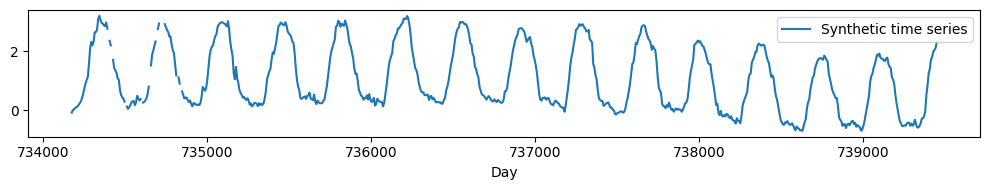

In [3]:
data_preprocessor = generate_one_synthetic_time_series(used_for_generation=False)
data_preprocessor.time_series['y'] = y_disp
data_preprocessor.time_series['timesteps'] = timestamps
data_preprocessor.time_step_interval = 7
data_preprocessor.export_to_csv(indices_train_val_test=[216, 268, -1],
                     observation_file_paths = obs_file_paths,
                     datetime_file_paths=date_file_paths,
                     start_datetime=datetime(2010, 2, 7, 12, 0, 0))
val_datetime_values = data_preprocessor.get_validation_datetime_values()
data_preprocessor.plot()

## 2. Train BDLM
The components are AA + AR + LSTM. The AR component here learns automatically the phi_AR and sigma_AR

### BDLM training configuration

In [4]:
num_epochs: int = 30
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

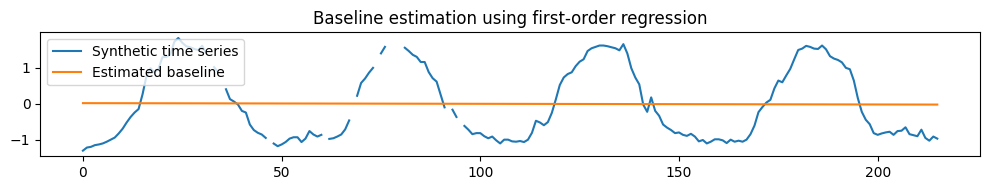

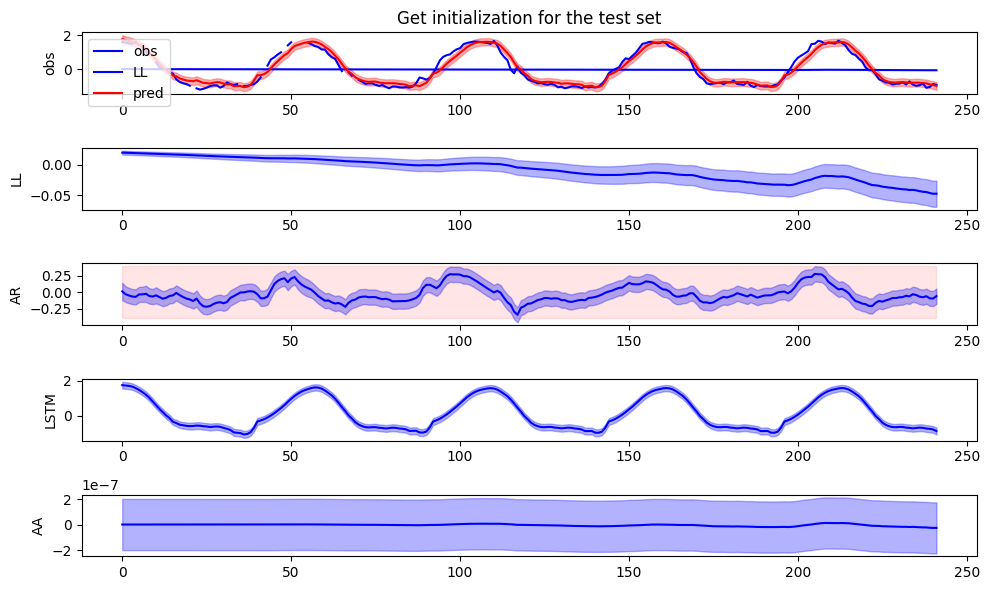

In [5]:
BDLM = BDLM_trainer(num_epochs=num_epochs,
                    batch_size=batch_size,
                    sigma_v=sigma_v,
                    output_col=output_col,
                    num_features=num_features,
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    seq_stride=seq_stride)
BDLM.load_datasets(obs_file_paths, date_file_paths, time_covariates)
BDLM.estimate_initial_baseline(plot=True)

# BDLM.train(plot=True, early_stopping=True, patience=10)
# BDLM.save_LSTM_model(path = './saved_param/CASC_LGA007PIAP_E010_2024_07/lstm_y_V2.pth')
# # Store the smoothed initial value from training + validation sets, and remove the phi_AR hidden state
# print(BDLM.phi_AR)
# print(BDLM.Sigma_AR)
# print(BDLM.var_phi_AR)
# print(BDLM.var_Sigma_AR)

BDLM.phi_AR = 0.7222478052030589
BDLM.Sigma_AR = 0.0080873570245455
BDLM.var_phi_AR = 0.006625828644560832
BDLM.var_Sigma_AR = 6.923906665191422e-06

BDLM.load_LSTM_model(path = './saved_param/CASC_LGA007PIAP_E010_2024_07/lstm_y_V2.pth')

LSTM_net, init_mu_lstm, init_var_lstm, init_z, init_Sz, init_mu_W2b, init_var_W2b,\
last_seq_obs, last_seq_datetime, last_lstm_x = BDLM.get_testing_model_initials(val_datetime_values=val_datetime_values, plot=True)
init_z[2]=0

## 3. Check if AA is correct

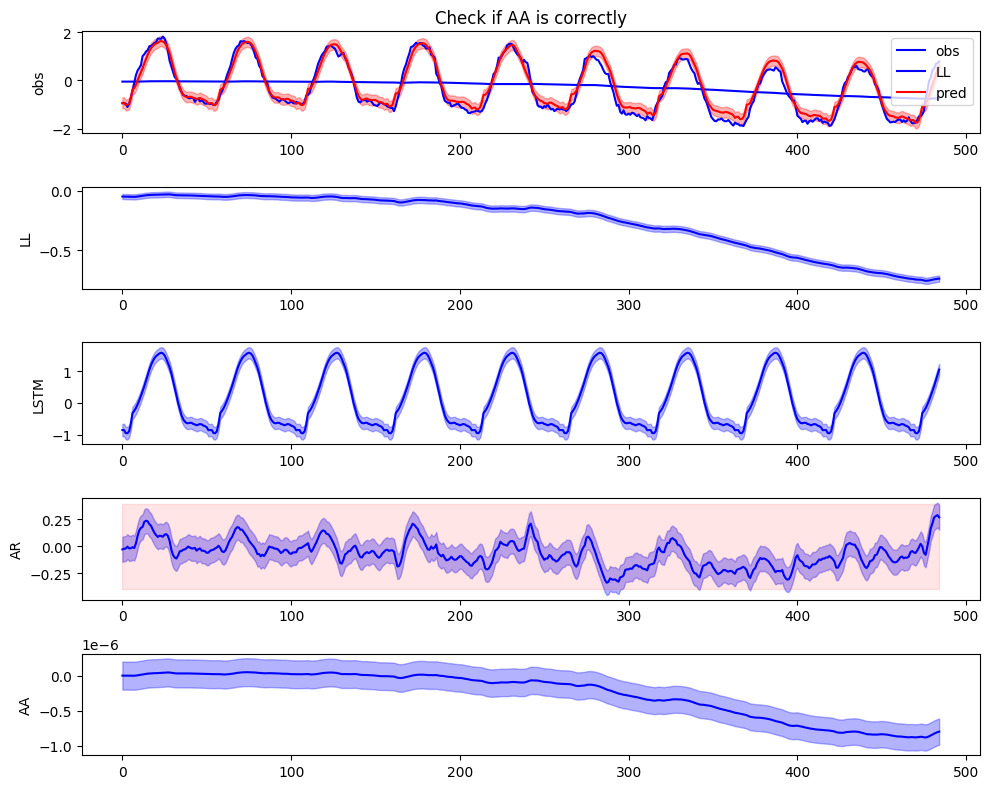

In [6]:
BDLM.check_AA(plot = True)

## 4. RL agent

In [7]:
# Training RL
# Initialize environment
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env
train_dtl = BDLM.train_dtl
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                    ts_model=BDLM.model, step_look_back=64)
state, _ = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),\
                    net_test=LSTM_net, init_mu_W2b=init_mu_W2b, init_var_W2b=init_var_W2b, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
                    phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio)
n_actions = env.action_space.n
n_observations = len(state['hidden_states'])

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import random
from examples.data_loader import SyntheticTimeSeriesDataloader

from src.RL_functions.helpers import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

from itertools import count


In [9]:
class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size=16):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3_pi = nn.Linear(24, self.action_size)
        self.fc3_v = nn.Linear(24, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return torch.clamp(self.softmax(x), min=1e-30)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x

In [10]:
episode_durations = []
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [11]:
class AgentConfig:
    # Learning
    gamma = 0.99
    plot_every = 10
    update_freq = 1
    k_epoch = 3
    learning_rate = 0.02
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01

    # Memory
    memory_size = 500

    train_cartpole = True

In [12]:
class Agent(AgentConfig):
    def __init__(self):
        self.env = env
        self.action_size = self.env.action_space.n  # 2 for cartpole
        if self.train_cartpole:
            self.policy_network = MlpPolicy(action_size=self.action_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.FloatTensor([])
        }
        self.episode_rewards = []

    def new_random_game(self, i_episode):
        sample = random.random()
        step_look_back = 64
        observation_save_path = 'data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_observation_200episodes_debug.csv'
        datetime_save_path = 'data/CASC_LGA007PIAP_E010_2024_07/RLDS_y_datetime_200episodes_debug.csv'
        syn_ts_all = self._load_data_from_csv(observation_save_path).T
        num_steps_per_episode = len(syn_ts_all[0])
        self.anm_pos = np.random.randint(step_look_back + BDLM.input_seq_len, num_steps_per_episode)
        phi_AR = BDLM.phi_AR
        Sigma_AR = BDLM.Sigma_AR
        Sigma_AA_ratio = BDLM.Sigma_AA_ratio
        phi_AA = BDLM.phi_AA
        if sample < 1:
            train_dtl = SyntheticTimeSeriesDataloader(
                x_file=observation_save_path,
                select_column=i_episode,
                date_time_file=datetime_save_path,
                add_anomaly = True,
                anomaly_magnitude=np.random.uniform(-0.05, 0.05),
                anomaly_start=self.anm_pos,
                x_mean=BDLM.train_dtl.x_mean,
                x_std=BDLM.train_dtl.x_std,
                output_col=BDLM.output_col,
                input_seq_len=BDLM.input_seq_len,
                output_seq_len=BDLM.output_seq_len,
                num_features=BDLM.num_features,
                stride=BDLM.seq_stride,
                time_covariates=BDLM.time_covariates,
            )
            self.anomaly_injected = True
        else:
            train_dtl = SyntheticTimeSeriesDataloader(
                x_file=observation_save_path,
                select_column = i_episode,
                date_time_file=datetime_save_path,
                x_mean=BDLM.train_dtl.x_mean,
                x_std=BDLM.train_dtl.x_std,
                output_col=BDLM.output_col,
                input_seq_len=BDLM.input_seq_len,
                output_seq_len=BDLM.output_seq_len,
                num_features=BDLM.num_features,
                stride=BDLM.seq_stride,
                time_covariates=BDLM.time_covariates,
            )
            self.anomaly_injected = False

        self.env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, step_look_back=step_look_back)

        state, info = self.env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),
                    net_test = BDLM.net_test, init_mu_W2b = None, init_var_W2b = None, phi_AR = phi_AR, Sigma_AR = Sigma_AR,
                    phi_AA = phi_AA, Sigma_AA_ratio = Sigma_AA_ratio)
        state = state['hidden_states']
        # state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # Nomalize the state
        # Compute the stationary standard deviation for AR
        self.AR_std_stationary = np.sqrt(BDLM.Sigma_AR/(1 - BDLM.phi_AR**2))
        self.LA_var_stationary = BDLM.Sigma_AA_ratio *  BDLM.Sigma_AR/(1 - BDLM.phi_AA**2)
        if step_look_back == 64:
            self.seg_len = 8
        state = normalize_array_two_parts(state, 0, np.sqrt(self.LA_var_stationary), \
                                        0, self.AR_std_stationary, self.seg_len)
        return state

    def train(self, plot_samples=True):
        episode = 0
        step = 0
        num_episodes = 200

        # A new episode
        for i_episode in range(num_episodes):
            start_step = step
            episode += 1
            episode_length = 0
            total_reward_one_episode = 0

            # Get initial state
            # state, reward, action, terminal, truncated = self.new_random_game(i_episode)
            state = self.new_random_game(i_episode)
            action = self.env.action_space.sample()
            current_state = state

            # A step in an episode
            for t in count():
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.pi(torch.FloatTensor(current_state).to(device))
                # Select action according to the most confident choice
                max_idx = torch.argmax(prob_a)
                action = max_idx.item()

                # # Sample action from the distribution
                # action = torch.distributions.Categorical(prob_a).sample().item()

                # Act
                state, reward, terminal, truncated, info = self.env.step(action)

                # state = torch.tensor(state['hidden_states'], dtype=torch.float32, device=device).unsqueeze(0)
                state = state['hidden_states']
                state = normalize_array_two_parts(state, 0, np.sqrt(self.LA_var_stationary), 0, self.AR_std_stationary, self.seg_len)

                new_state = state

                done = terminal or truncated

                self.add_memory(current_state, action, reward, new_state, done, prob_a[action].item())

                current_state = new_state

                total_reward_one_episode += reward

                if done:
                    self.episode_rewards.append(total_reward_one_episode)

                    episode_length = step - start_step
                    self.finish_path(episode_length)

                    episode_durations.append(t + 1)
                    self._plot_rewards(metric = self.episode_rewards, ylim=[-1000, 200])

                    break

            if plot_samples:
                timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
                mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
                var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
                mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
                var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
                # if track_intervention_taken_times[i_episode] == 1:
                if True:
                    # Plot prediction
                    fig = plt.figure(figsize=(15, 12))
                    gs = gridspec.GridSpec(5, 1)
                    ax0 = plt.subplot(gs[0])
                    ax1 = plt.subplot(gs[2])
                    ax2 = plt.subplot(gs[3])
                    ax3 = plt.subplot(gs[4])
                    ax4 = plt.subplot(gs[1])

                    ax0.plot(timesteps, info['measurement_one_episode'], label='True')
                    # plot the standard deviation of the prediction
                    ax0.plot(timesteps, mu_prediction_one_episode, label='Predicted')
                    ax0.fill_between(timesteps, mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),\
                                        mu_prediction_one_episode + np.sqrt(var_prediction_one_episode), color='gray', alpha=0.2)
                    ax0.set_title(f'Predicted vs True, epoch {i_episode+1}')
                    ax0.set_ylabel('y')
                    delta_max_min = np.max(mu_prediction_one_episode) - np.min(mu_prediction_one_episode)
                    ax0.set_ylim(np.min(mu_prediction_one_episode)-0.05*delta_max_min, np.max(mu_prediction_one_episode)+0.05*delta_max_min)
                    if self.anomaly_injected:
                        anomaly_pos = timesteps[self.anm_pos-64]
                        ax0.axvline(x=anomaly_pos, color='gray', linestyle='--')
                    ax0.legend()

                    ax1.plot(timesteps, mu_hidden_states_one_episode[:,2], label='LA')
                    ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),\
                                        mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]), color='gray', alpha=0.2)
                    ax1.set_ylabel('LA')

                    ax2.plot(timesteps, mu_hidden_states_one_episode[:,-1], label='PD')
                    ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),\
                                        mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='gray', alpha=0.2)
                    ax2.set_ylabel('PD')

                    ax3.fill_between(timesteps, np.zeros_like(timesteps)-3*self.AR_std_stationary, np.zeros_like(timesteps)+3*self.AR_std_stationary, color='red', alpha=0.1)
                    ax3.plot(timesteps, mu_hidden_states_one_episode[:,-2], label='AR')
                    ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),\
                                        mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='gray', alpha=0.2)
                    ax3.set_ylabel('AR')

                    # ax4.plot(Q_values_all[0], label='Q_value_0')
                    # ax4.plot(Q_values_all[1], label='Q_value_1')
                    # ax4.set_ylabel('Q_values')
                    # ax4.set_xlim(ax0.get_xlim())
                    # ax4.legend(loc='upper left')
                    plt.show()
                    # filename = f'saved_results/Qvalues_training/Qvalues_episode#{i_episode}.png'
                    # plt.savefig(filename)
                    # plt.close()

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()

        print('Complete')
        self._plot_rewards(metric = self.episode_rewards, ylim=[-1000, 200])
        plt.show()
        plt.ioff()

    def update_network(self):
        # get ratio
        pi = self.policy_network.pi(torch.FloatTensor(self.memory['state']).to(device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action']))
        old_probs_a = torch.FloatTensor(self.memory['action_prob'])
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss
        surr1 = ratio * torch.FloatTensor(self.memory['advantage'])
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.FloatTensor(self.memory['advantage'])
        pred_v = self.policy_network.v(torch.FloatTensor(self.memory['state']).to(device))
        v_loss = 0.5 * (pred_v - self.memory['td_target']).pow(2)  # Huber loss

        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy])
        self.loss = (-torch.min(surr1, surr2) + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]

        td_target = torch.FloatTensor(reward) + \
                    self.gamma * self.policy_network.v(torch.FloatTensor(next_state)) * torch.FloatTensor(terminal)
        delta = td_target - self.policy_network.v(torch.FloatTensor(state))
        delta = delta.detach().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'], td_target.data), dim=0)
        self.memory['advantage'] += advantages

    def _load_data_from_csv(self, data_file: str, skip_row = 0, select_column = None) -> pd.DataFrame:
        """Load data from csv file"""

        data = pd.read_csv(data_file, skiprows=skip_row, delimiter=",", header=None)

        # if select_column is not given by the user, reshape the data to (-1, 1)
        if select_column is None:
            return data.values
        else:
            # if select_column is given by the user, return the selected column
            return data.values[:, select_column].reshape(-1, 1)

    def _plot_rewards(self, metric, show_result=False, ylim=None):
        plt.figure(1)
        durations_t = torch.tensor(metric, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Rewards')
        plt.plot(durations_t.numpy())
        if ylim is not None:
            plt.ylim(ylim[0], ylim[1])

        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        is_ipython = 'inline' in matplotlib.get_backend()
        if is_ipython:
            from IPython import display
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

In [13]:
agent = Agent()
# agent.train()

### Test

In [14]:
from itertools import count
import torch
from src.RL_functions.dqn_lstm_agent import *

step_look_back = 64
env = LSTM_KF_Env(render_mode=None, data_loader=BDLM.test_dtl, \
                    ts_model=BDLM.model, step_look_back=step_look_back)

state, info = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),
                        net_test = LSTM_net, init_mu_W2b = init_mu_W2b, init_var_W2b = init_var_W2b, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
                        phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio)
state = state['hidden_states']
current_state = state
intervention_index =[]
intervention_taken = False
LA_var_stationary = BDLM.Sigma_AA_ratio *  BDLM.Sigma_AR/(1 - BDLM.phi_AA**2)
AR_std_stationary = np.sqrt(BDLM.Sigma_AR/(1 - BDLM.phi_AR**2))
if step_look_back == 64:
    seg_len = 8
RL_step_taken = 0
probs_all = []
for t in count():

    # Choose action
    prob_a = agent.policy_network.pi(torch.FloatTensor(current_state).to(device))
    probs_all.append(prob_a.detach().numpy())
    # action = torch.distributions.Categorical(prob_a).sample().item()
    max_idx = torch.argmax(prob_a)
    action = max_idx.item()
    action = 0

    # Act
    state, reward, terminal, truncated, info = env.step(action)
    state = state['hidden_states']
    state = normalize_array_two_parts(state, 0, np.sqrt(LA_var_stationary), 0, AR_std_stationary, seg_len)

    new_state = state
    current_state = new_state

    # if RL_step_taken >= 900-64:
    #     state, reward, terminated, truncated, info = env.step(action, add_anomaly = True, anomaly_scale = 1.1e-2*(RL_step_taken-(900-64)))
    # else:
    #     state, reward, terminated, truncated, info = env.step(action)

    # RL_step_taken += 1

    if action == 1:
        intervention_index.append(t + step_look_back + 1)
        intervention_taken = True

    done = terminal or truncated
    if done:
        break

# Fill 65 rows of [nan, nan] values in front of Q_values_all
probs_all = [[np.nan, np.nan]] * 65 + probs_all
probs_all = np.array(probs_all).T

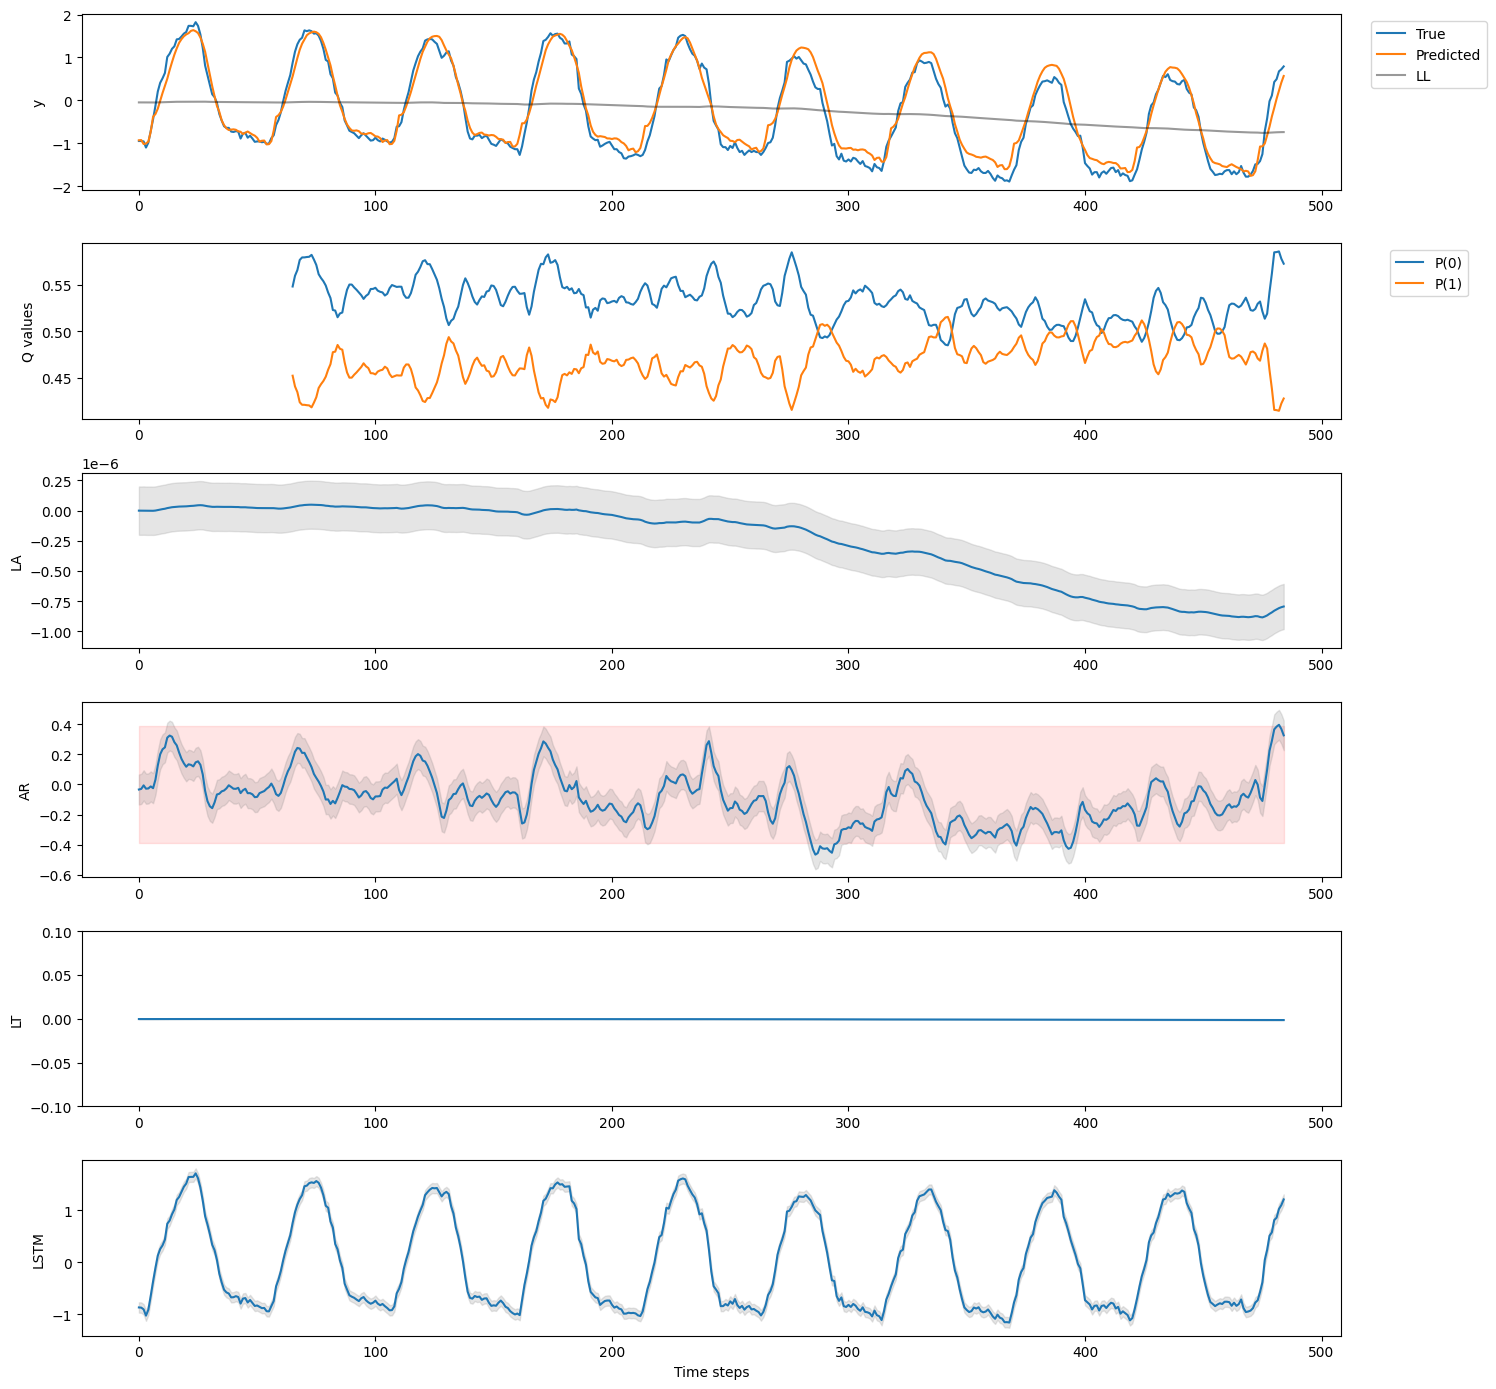

In [15]:
# Plot prediction
timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 14))
gs = gridspec.GridSpec(6, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[2])
ax2 = plt.subplot(gs[3])
ax3 = plt.subplot(gs[4])
ax4 = plt.subplot(gs[5])
ax5 = plt.subplot(gs[1])

ax0.plot(timesteps, info['measurement_one_episode'], label='True')
ax0.plot(timesteps, mu_prediction_one_episode , label='Predicted')
for count, i in enumerate(intervention_index):
    if count == 0:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
    else:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--')
ax0.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
# ax0.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
#                     mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
ax0.set_ylabel('y')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))


ax1.plot(timesteps, mu_hidden_states_one_episode[:,2], label='LA')
ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),\
                    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]), color='gray', alpha=0.2)
ax1.set_ylabel('LA')

ax2.fill_between(timesteps, np.zeros_like(timesteps)-3*AR_std_stationary, np.zeros_like(timesteps)+3*AR_std_stationary, color='red', alpha=0.1)
ax2.plot(timesteps, mu_hidden_states_one_episode[:,-2], label='AR')
ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),\
                    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='gray', alpha=0.2)
ax2.set_ylabel('AR')
# ax2.set_ylim(-1.1, 1.1)

ax3.plot(timesteps, mu_hidden_states_one_episode[:,1], label='LT')
ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,1] - np.sqrt(var_hidden_states_one_episode[:,1,1]),\
                    mu_hidden_states_one_episode[:,1] + np.sqrt(var_hidden_states_one_episode[:,1,1]), color='gray', alpha=0.2)
ax3.set_ylabel('LT')
ax3.set_ylim(-0.1,0.1)

ax4.plot(timesteps, mu_hidden_states_one_episode[:,-1], label='LSTM')
ax4.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),\
                    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='gray', alpha=0.2)
ax4.set_ylabel('LSTM')
ax4.set_xlabel('Time steps')

ax5.plot(timesteps, probs_all[0], label='P(0)')
ax5.plot(timesteps, probs_all[1], label='P(1)')
ax5.set_ylabel('Q values')
# set x axis to be the same as ax0
ax5.set_xlim(ax0.get_xlim())
ax5.legend(loc='upper center', bbox_to_anchor=(1.07,1))

plt.show()